[![在 Colab 中打开](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-external-memory.ipynb) [![在 LangChain Academy 中打开](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239440-lesson-6-chatbot-w-summarizing-messages-and-external-memory)


# 具有消息摘要和外部数据库记忆的聊天机器人

## 回顾

我们已经介绍了如何自定义图状态的 schema 与 reducer。

我们也展示了在图状态中裁剪或筛选消息的多种技巧。

我们借助这些概念构建了一款会生成对话摘要的记忆型聊天机器人。

## 目标

但如果我们希望聊天机器人拥有可以无限期保留的记忆呢？

现在我们将介绍一些支持外部数据库的高级 checkpointer。

此处演示如何使用 [Sqlite 作为 checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer)，你也可以选择其他 checkpointer，例如 [Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/)。


In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_openai

In [2]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


# _set_env("OPENAI_API_KEY")
_set_env("DASHSCOPE_API_KEY")

## Sqlite

一个不错的起点是 [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer)。

Sqlite 是一个[小巧、快速且极受欢迎](https://x.com/karpathy/status/1819490455664685297) 的 SQL 数据库。

如果我们提供 `":memory:"`，它会创建一个内存中的 Sqlite 数据库。


In [3]:
import sqlite3

# In memory
conn = sqlite3.connect(":memory:", check_same_thread=False)

不过，如果我们提供数据库路径，它就会替我们创建一个数据库！


In [4]:
# pull file if it doesn't exist and connect to local db
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

--2025-09-26 01:21:56--  https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db
正在解析主机 github.com (github.com)... 20.205.243.166
正在连接 github.com (github.com)|20.205.243.166|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 302 Found
位置：https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db [跟随至新的 URL]
--2025-09-26 01:21:58--  https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db
正在解析主机 raw.githubusercontent.com (raw.githubusercontent.com)... ::, 0.0.0.0
正在连接 raw.githubusercontent.com (raw.githubusercontent.com)|::|:443... 失败：Connection refused。
正在连接 raw.githubusercontent.com (raw.githubusercontent.com)|0.0.0.0|:443... 失败：Connection refused。


In [5]:
# Here is our checkpointer
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver(conn)

我们重新定义一下聊天机器人。


In [6]:
# from langchain_openai import ChatOpenAI
from langchain_community.chat_models import ChatTongyi
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

# model = ChatOpenAI(model="gpt-4o",temperature=0)
model = ChatTongyi(model="qwen-plus", temperature=0)


class State(MessagesState):
    summary: str


# Define the logic to call the model
def call_model(state: State):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}


def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}


# Determine whether to end or summarize the conversation
def should_continue(state: State):
    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


现在，只需使用 sqlite checkpointer 重新编译即可。


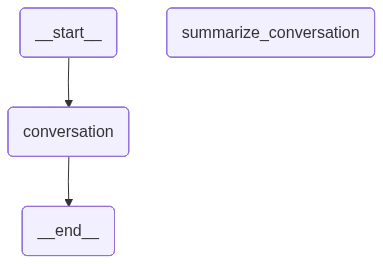

In [7]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

接下来我们可以多次调用这个图。


In [8]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Lance! ٩(◕‿◕｡)۶ How's your day going? I'd love to hear what's on your mind or help with anything you need!
================================== Ai Message ==================================

Your name is Lance! I'm glad to remember that. 😊 Is there something special you'd like to talk about, Lance?
================================== Ai Message ==================================

That’s awesome, Lance! 🏈 The San Francisco 49ers have such a rich history—great choice! Whether you're hyped for the next game, mourning a tough loss, or just loving the team through thick and thin, I’m here for it.  

Are you excited about the upcoming season? Or do you have a favorite player or all-time 49ers moment? Let’s talk some football! 💚🤍


来确认一下状态确实保存在本地。


In [9]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='47acaf20-35ec-4cf0-9595-348ef7d1ebff'), AIMessage(content="Hi Lance! ٩(◕‿◕｡)۶ How's your day going? I'd love to hear what's on your mind or help with anything you need!", additional_kwargs={}, response_metadata={'model_name': 'qwen-plus', 'finish_reason': 'stop', 'request_id': '11ea5590-bd46-471e-8fe4-528804c45170', 'token_usage': {'input_tokens': 13, 'output_tokens': 37, 'total_tokens': 50, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--57849513-051e-46df-901b-bea7112d31f4-0'), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='207015cf-989a-43a5-b875-3cdb96345e02'), AIMessage(content="Your name is Lance! I'm glad to remember that. 😊 Is there something special you'd like to talk about, Lance?", additional_kwargs={}, response_metadata={'model_name': 'qwen-plus', 'finish_reason': 'stop', 'request_id': '8d143933-54f8-4c6b

### 持久化状态

使用像 Sqlite 这样的数据库意味着状态能够持久化！

例如，我们可以重新启动 notebook 内核，依然可以从磁盘上的 Sqlite 数据库加载状态。


In [8]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", id='d5bb4b3f-b1e9-4f61-8c75-7a7210b30253'), AIMessage(content="Hello again, Lance! It's great to hear from you. Since you like the 49ers, is there a particular player or moment in their history that stands out to you? Or perhaps you'd like to discuss their current season? Let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 337, 'total_tokens': 387}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5', 'finish_reason': 'stop', 'logprobs': None}, id='run-dde04d51-d305-4a9e-8ad5-6bdf5583196e-0', usage_metadata={'input_tokens': 337, 'output_tokens': 50, 'total_tokens': 387}), HumanMessage(content="what's my name?", id='d7530770-f130-4a05-a602-a96fd87859c6'), AIMessage(content='Your name is Lance! How can I assist you today? Would you like to talk more about the San Francisco 49ers or something else?', additional_kwargs={'

## LangGraph Studio

**⚠️ 免责声明**

自这些视频录制以来，我们已经更新了 Studio，使其可以在本地运行并在浏览器中打开。与视频中展示的桌面应用相比，现在推荐采用这种方式。关于本地开发服务器的文档请参阅 [这里](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server)，另请参阅 [这里](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server) 了解如何运行本地 Studio。要启动本模块 `/studio` 目录中的本地开发服务器，请在终端运行：

```
langgraph dev
```

你将看到类似如下的输出：
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

打开浏览器，访问 Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`。
